# **Brain Tumor Detection**
## **Võ Thành Hoàng Sơn - 19DH110660**



##0. Dataset: Brian Tumor Dataset
*url: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset*

    Được giới thiệu bởi: PREET VIRADIYA
    Là một tập dữ liệu hình ảnh X-Ray bộ não người. Bao gồm 4600 mẫu trong đó
      - 2087 hình ảnh bình thường
      - 2513 hình ảnh có khối U
    Dataset này dùng để nhận diện khối u trong hình ảnh X-ray não người

    Dữ liệu đã được lưu trữ tại: [https://drive.google.com/drive/folders/1qMj-VWgO3XeYPI4r-IPhodMJrpjTWnJ1?usp=sharing]



## 1. Mount drive, import dataset, import lib
 - Dataset url: https://drive.google.com/drive/folders/1qMj-VWgO3XeYPI4r-IPhodMJrpjTWnJ1?usp=sharing
 

In [ ]:
url = 'https://drive.google.com/drive/folders/1qMj-VWgO3XeYPI4r-IPhodMJrpjTWnJ1?usp=sharing'
import gdown
gdown.download_folder(url,output='/content/dataset')

# unzip dataset from drive
!unzip -o -q "/content/dataset/Brain_Tumor_Dataset.zip" 

Retrieving folder list


Processing file 1EHgCqXST9fzZIDzh0cbaU0f9IiShqyFT Brain_Tumor_Dataset.zip
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1EHgCqXST9fzZIDzh0cbaU0f9IiShqyFT
To: /content/dataset/Brain_Tumor_Dataset.zip
100%|██████████| 112M/112M [00:00<00:00, 267MB/s]
Download completed


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras import layers
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sys


import warnings
warnings.filterwarnings("ignore")

from keras import Model  

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau

## 2. Load dataset
**Phương pháp:** Ta tiến hành chia dataset thành 3 tập:

    + Train data:  64%
    + Validation data: 16%
    + Test data: 20% 


In [ ]:
seed = 42
metadata = tf.keras.utils.image_dataset_from_directory("/content/Brain Tumor Data Set/Brain Tumor Data Set",
                                                       validation_split=.2,
                                                       shuffle=True,
                                                       subset='training',
                                                       seed = seed,
                                                       batch_size=None,
                                                       label_mode='binary')
testdata = tf.keras.utils.image_dataset_from_directory("/content/Brain Tumor Data Set/Brain Tumor Data Set",
                                                       validation_split=.2,
                                                       shuffle=True,
                                                       subset='validation',
                                                       seed = seed,
                                                       batch_size=None,
                                                       label_mode='binary')

split = int(3612*.8)
traindata = metadata.take(split)
validdata = metadata.take(3612-split)
print("--"*50)
print(f"Train data: {len(traindata)}")
print(f"Validation data: {len(validdata)}")
print(f"Test data: {len(testdata)}")

**Nhận xét:** 
    Chỉ load được 4514 hình ảnh vì hàm image_dataset_from_directory không load được hình ảnh dưới dạng .tiff

    Sau khi load: 
      - Tập train: 2889 hình ảnh
      - Tập valid: 723 hình ảnh 
      - Tập test: 902 hình ảnh


In [ ]:
def decoder(code):
  if code == 0:
    return "Cancer"
  else: return "Healthy"

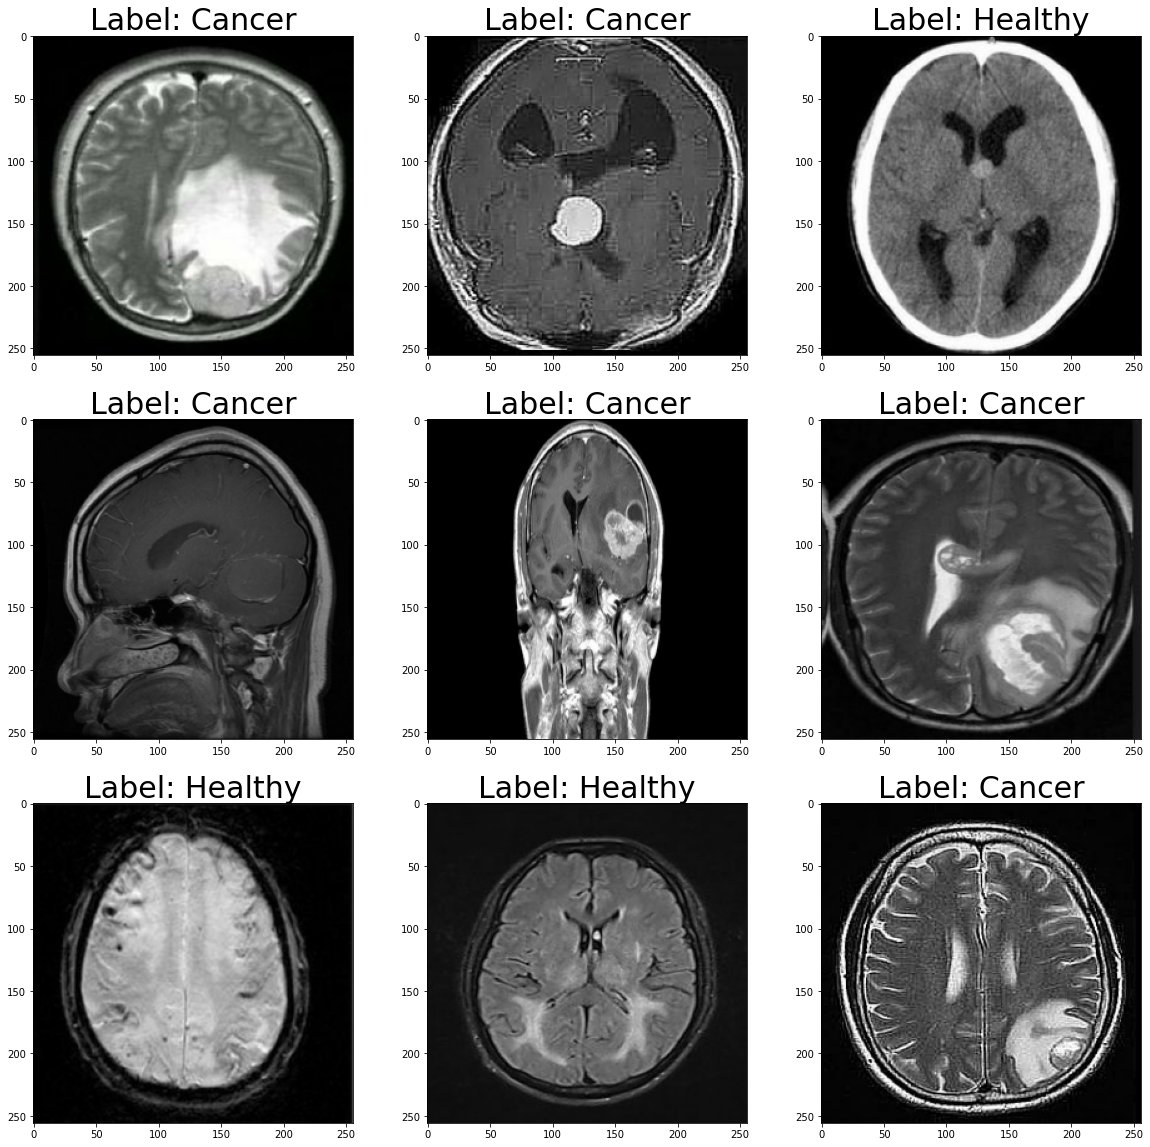

In [ ]:
plt.figure(figsize = (20,20))
for idx in range(9):
  img,label = next(iter(traindata))
  plt.subplot(3,3,idx+1)
  plt.imshow(np.array(img).astype('uint8'))
  plt.title(f"Label: {decoder(label)}",fontdict={'fontsize':30})
  

**Tóm tắt:** Tập dữ liệu có 4514 mẫu là ảnh MRI não đã thu thập được. Trong đó các mẫu được chia thành 2 loại:
  + 0: Cancer: là hình ảnh MRI người bị ung thư não
  + 1: Healthy: là hình ảnh MRI người không bị ung thư não 

**Phương pháp** 
  1. Kiểm tra độ cân bằng của bộ dữ liệu
  2. Số mẫu chỉ có 4516 mẫu tương đối ít cần tăng số lượng mẫu bằng cách:
    + Xoay hình ảnh
    + Tăng giảm độ sáng
    + Lật hình ảnh (flip)



### 2.1 Data balancing

In [ ]:
# lấy label đúng của tập test

train_label = pd.DataFrame([int(label) for img,label in list(traindata)])
valid_label = pd.DataFrame([int(label) for img,label in list(validdata)])
target = pd.DataFrame([int(label) for img,label in list(testdata)])


Text(0.5, 0, 'Test set')

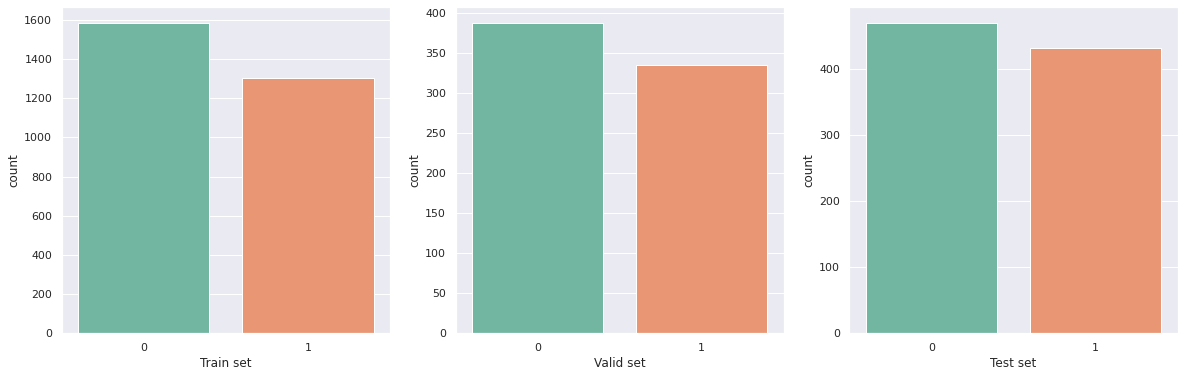

In [ ]:
# Plot độ cân bằng dữ liệu
sns.set(style='darkgrid', palette='Set2')
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
sns.countplot(train_label[0])
plt.xlabel('Train set')
plt.subplot(1,3,2)
sns.countplot(valid_label[0])
plt.xlabel("Valid set")
plt.subplot(1,3,3)
sns.countplot(target[0])
plt.xlabel("Test set")



**Nhận xét**:

      Dữ liệu trong 3 tập được chia khá tương đồng, không cần cân bằng dữ liệu

### 2.2 Data preprocessing

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
prepare_img = Sequential([ 
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2)
  ])

resize_rescale = Sequential([
  layers.Resizing(256, 256),
  layers.Rescaling(1./255)
])

decoder_label =  tf.keras.layers.CategoryEncoding(num_tokens=2,output_mode="one_hot")

def preprocessing(data, batch_size=16 ,repeat_count=False, random_transform=True):

  data = data.map(lambda img,label:(resize_rescale(img),decoder_label(label)), num_parallel_calls=AUTOTUNE)

  if random_transform:
      data = data.map(lambda img, label:(prepare_img(img),label),num_parallel_calls=AUTOTUNE)

  if batch_size != 0:
    data = data.batch(batch_size)
  if(repeat_count):
    data = data.repeat()

  data = data.prefetch(buffer_size=AUTOTUNE)
  return data

In [ ]:
batch_size=32
train = preprocessing(traindata, batch_size=batch_size,repeat_count=True)
valid = preprocessing(validdata, batch_size=batch_size)
test = preprocessing(testdata, batch_size=1,random_transform=False)

**Nhận xét:** 

    Dữ liệu sau khi được xử lý có kiểu DataPrefetch trong đó tập train và valid có batch là 32.

## 3. Define model
    Sữ dụng mô hình CNN có cấu trúc như sau:
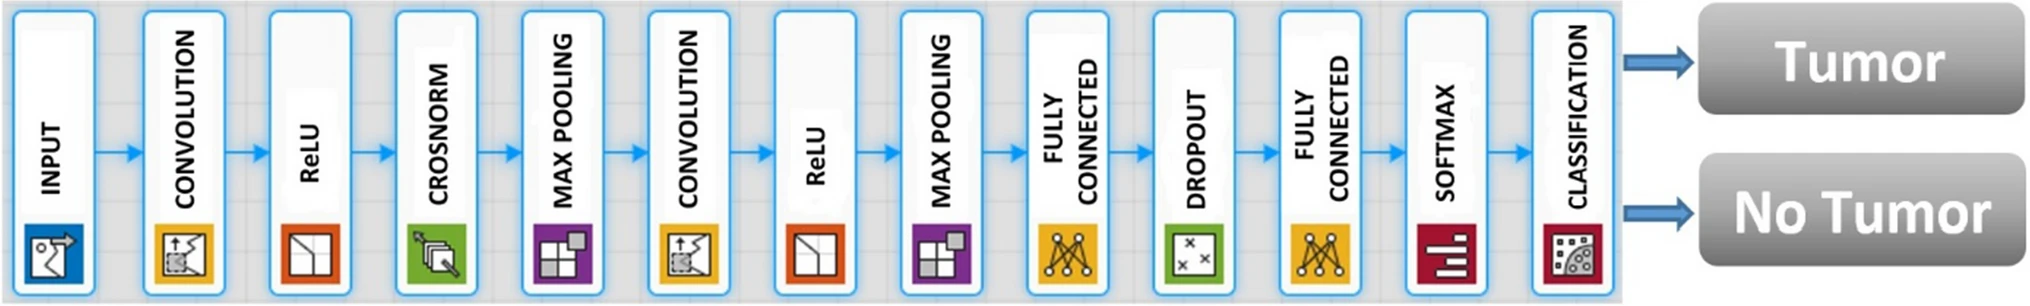


  *src: https://link.springer.com/article/10.1007/s40998-021-00426-9*

**Phương pháp huấn luyện:**

      - Chúng ta sẽ dụng hàm tối ưu là: Adam với hệ số học ban đầu là 1e-3
      - Sử dụng phương pháp giảm hệ số học e-1 (ReduceLROnPlateau) nếu val_loss không giảm sau mỗi 3 epochs
      - Lưu trữ trọng số của mô hình (ModelCheckpoint) nếu val_loss tốt hơn
      - Sử dụng phương pháp early stopping để dừng quá trình huấn luyện nếu giá trị accuracy không tối ưu hơn sau mỗi 6 epochs
      - Sử dụng hàm mất mát là binary_crossentropy 

In [ ]:
name_exp = 'Brain_tumor'
init_lr = 1e-3
epochs = 100

In [ ]:
model = Sequential([
    layers.Conv2D(128, kernel_size = 6, input_shape=(256, 256, 3), activation ='relu', padding = 'same'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = 2),

    layers.Conv2D(96, kernel_size = 6, activation ='relu', padding = 'same'),
    layers.MaxPool2D(pool_size = 2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
  ])


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 128)     13952     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 96)      442464    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 96)       0         
 2D)                                                             
                                                      

**Nhận xét:** 

    - Số trọng số được huấn luyện trong mô hình là 201,784,802. 
    - Số trọng số không được huấn luyện là 256 (vì sử dụng Dropout 50%)

## 4. Training

In [ ]:
optim = Adam(lr=init_lr)
early = EarlyStopping(monitor = 'val_accuracy', patience = 6)
reducelr = ReduceLROnPlateau( monitor='val_loss',
                             factor=tf.math.exp(-0.1), 
                             patience=3, 
                             verbose=1,
                             mode='auto',
                             min_lr=1e-5)
checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Shared/WritaleFolder/19DH110660_Võ Thành Hoàng Sơn/Lab3_DeepLearning/weight/{name_exp}_weight.h5',
                             monitor='val_loss', 
                             save_best_only=True,
                             mode='auto')
model.compile(optimizer=optim,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(train,validation_data=valid,epochs=epochs,steps_per_epoch=100,verbose=True,callbacks=[reducelr,checkpoint,early])

Epoch 1/100
100/100 [==============================] - 58s 567ms/step - loss: 7.5998 - accuracy: 0.6065 - val_loss: 0.6902 - val_accuracy: 0.5491 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 50s 502ms/step - loss: 0.4380 - accuracy: 0.8105 - val_loss: 0.6838 - val_accuracy: 0.5740 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 50s 501ms/step - loss: 0.2450 - accuracy: 0.9100 - val_loss: 0.6211 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 50s 506ms/step - loss: 0.1205 - accuracy: 0.9581 - val_loss: 0.3949 - val_accuracy: 0.9433 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 51s 511ms/step - loss: 0.0670 - accuracy: 0.9802 - val_loss: 0.1369 - val_accuracy: 0.9945 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 51s 510ms/step - loss: 0.0585 - accuracy: 0.9795 - val_loss: 0.0619 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 7/100
100/100 [=========================

**Nhận xét:**

    - Sau khi train sau 13 epochs quá trình huấn luyện đã kết thúc sớm vì val_accuracy đã đạt 1.0

### 4.1 Plot history

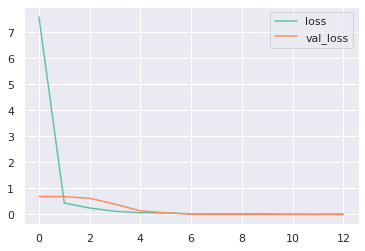

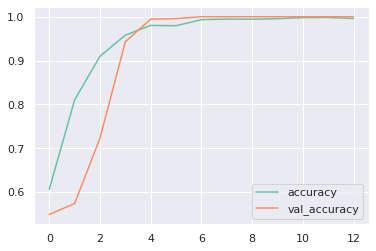

In [ ]:
log = pd.DataFrame(model.history.history)
    
log[['loss','val_loss']].plot()
log[['accuracy','val_accuracy']].plot()

## Save hist (Phải mount vào Drive)
# from google.colab import drive
# drive.mount('/content/drive')
# with open(f'/content/drive/MyDrive/Shared/WritaleFolder/19DH110660_Võ Thành Hoàng Sơn/Lab3_DeepLearning/log/{name_exp}_log.json', mode='wt') as f:
#     log.to_json(f)

**Nhận xét**: Sau khi huấn luyện qua 12 epochs 

    - Quá trình hội tụ rất nhanh khoảng 3 epochs giá trị hàm mất mát từ 0.6 xuống gần bằng 0
    - Sau đó mô hình dường như không có thay đổi quá nhiều
    - Quá trình huấn luyện được kết thúc sớm vì đã đạt giá trị accuracy = 1

## 5. Evaluate

**Phương pháp:**

    Ở đây ta tiến hành truyền lại trọng số tốt nhất trong quá trình huấn luyện và tiến hành kiểm tra trên tập test

In [ ]:
##Load best weight (Phải mount vào Drive)
# model.load_weights(f"/content/drive/MyDrive/Shared/WritaleFolder/19DH110660_Võ Thành Hoàng Sơn/Lab3_DeepLearning/weight/{name_exp}_weight.h5")
# optim = Adam(lr=3e-4)
model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])


In [ ]:
eval = model.evaluate(test)
np.round(eval,3)

902/902 [==============================] - 15s 14ms/step - loss: 0.1328 - accuracy: 0.9812 - precision_1: 0.9812 - recall_1: 0.9812


array([0.133, 0.981, 0.981, 0.981])

**Nhận xét:** 

    - Kết quả đánh giá sau là accuracy đạt 0.981 precision đạt 0.9812 với giá trị hàm mất mát là 0.133

### 5.1 Confusion matrix

**Phương pháp:**

    - Đầu tiên ta dự đoán các giá trị cho tập kiểm tra bằng 
    hàm predict
    - Sau đó ta chỉ số nhãn bằng argmax 

In [ ]:
true = []
pred = []
imgs = []
for img,label in test:
  true.append(np.argmax(label.numpy()[0]))
  pred.append(np.argmax(model.predict(img)))
  imgs.append(img[0])

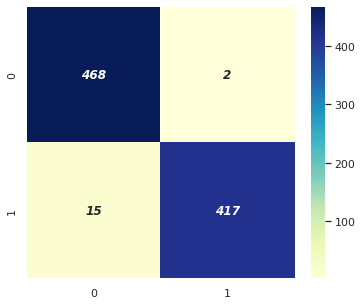

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(tf.math.confusion_matrix(true,pred),
            fmt='d',
            annot=True,
            cmap="YlGnBu",
            annot_kws={'fontsize':12,'fontstyle':'oblique','fontweight': 'heavy'})

**Nhận xét:**

    Sau khi predict trên tập test ta có thể thấy mô hình dự đoán vẫn còn sai đối với healthy là 2 nhãn đối với Cancer là 15 nhãn.
    Số dự đoán sai khá ít tuy nhiên đối với bài toán về y học thì ta cần cải thiện hơn.

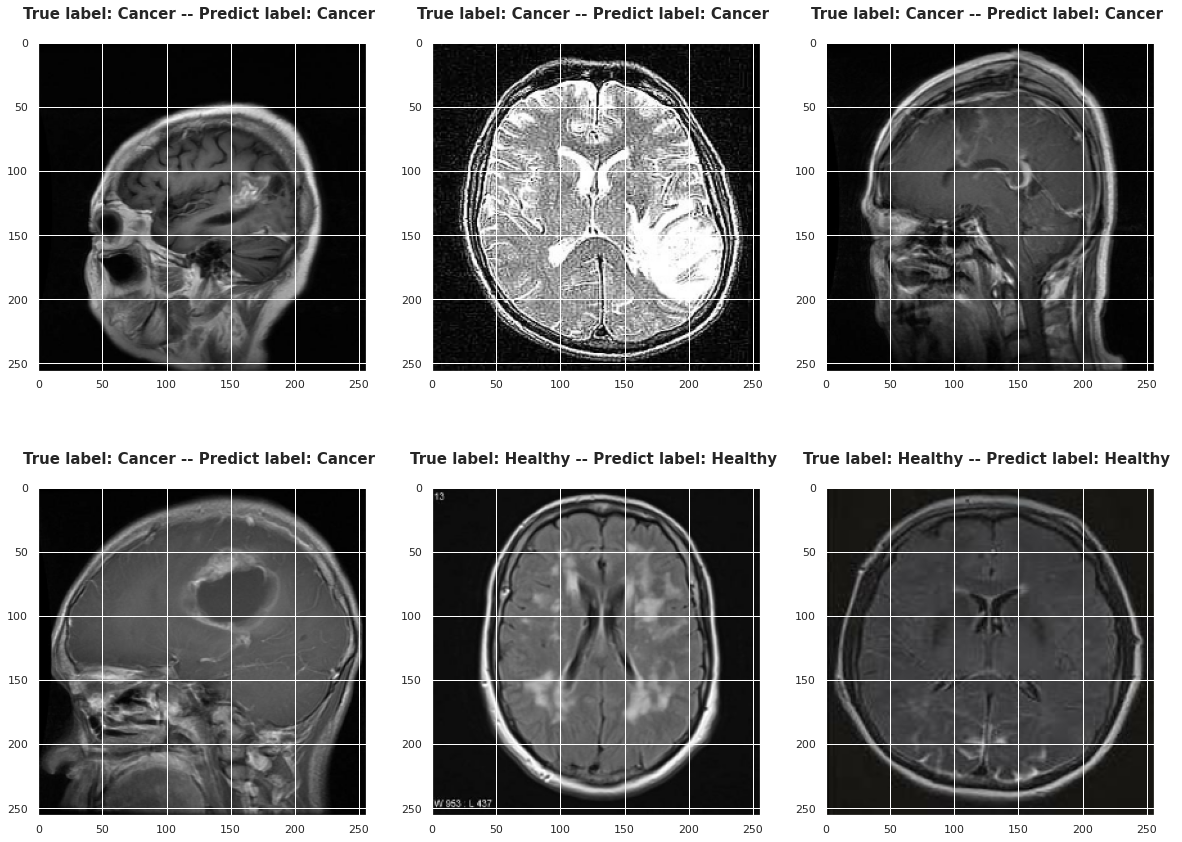

In [ ]:
plt.figure(figsize=(20,15))
for i in range(6):
  j = np.random.randint(0,len(imgs),1)[0]
  plt.subplot(2,3,i+1)
  plt.imshow(imgs[j])
  plt.title(f"True label: {decoder(true[j])} -- Predict label: {decoder(pred[j])} \n",
            fontdict={'fontsize': 15,'fontweight':'semibold'},)

**Nhận xét:**

    Khi thử hiển thị random một vài ảnh ta có thể thấy giá trị nhãn dự đoán tương đồng với nhãn thật.

#Summary:
      1. Tải và load bộ dữ liệu Brain Tumor Dataset
      2. Xử lý dữ liệu: Cân bằng và tiền xử lý đầu vào
      3. Tạo mô hình
      4. Huấn luyện mô hình
      5. Đánh giá và dự đoán kết quả.

#Future work
      - Tăng cường độ nhiễu cho hinh ảnh đầu vào
      - Bộ dữ liệu chỉ chưa hình ảnh MRI vì thế ta nên thêm các dạng ảnh scan khác như PET, MRA, CT ...